# Payment Fraud Detection

The Payment Fraud Detection System aims to identify and mitigate fraudulent activities in financial transactions, specifically within payment systems. As digital transactions become increasingly prevalent, ensuring the security and integrity of financial operations is crucial for maintaining trust and safeguarding users from financial losses.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow import feature_column

from os import getcwd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset_path = '../datasets/paysim1/PS_20174392719_1491204439457_log.csv'
data = pd.read_csv(dataset_path)

data.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [3]:
data.shape

(6362620, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [12]:
for col in data.columns:
    if data[col].dtype == object:
        print(col, ":", data[col].unique())

type : ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
nameOrig : ['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']
nameDest : ['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']


In [13]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [15]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Data Visualization

Text(0.5, 1.0, 'Class Distribution')

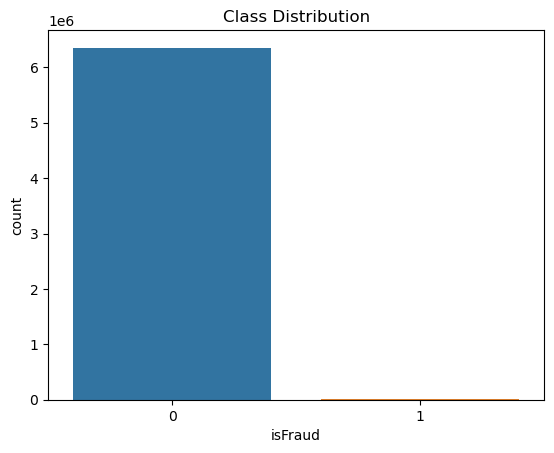

In [16]:
import seaborn as sns
sns.countplot(data=data, x='isFraud')
plt.title("Class Distribution")

Text(0.5, 1.0, 'Distribution of type of Transactions')

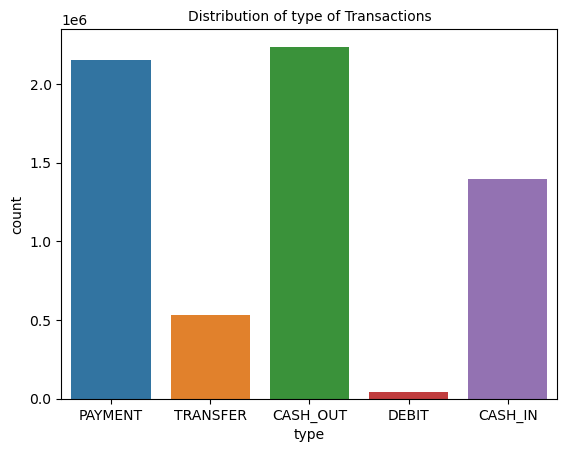

In [17]:
sns.countplot(data=data, x='type')
plt.title("Distribution of type of Transactions", fontsize=10)

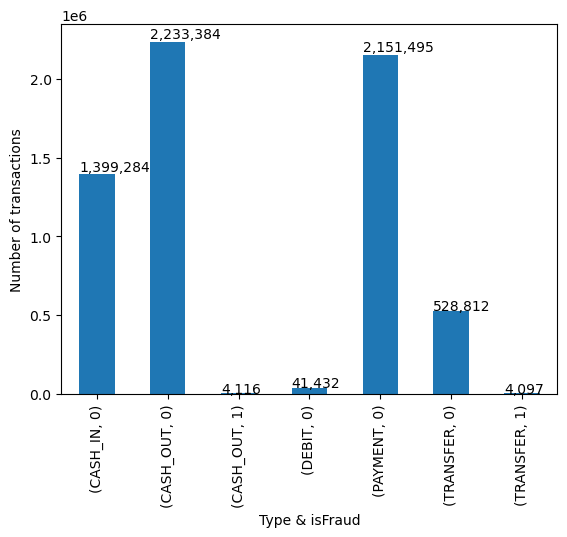

In [18]:
ax=data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

### Data Preprocessing

In [19]:
#categorical data
data.select_dtypes(include='object').columns

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [20]:
#numerical data
data.select_dtypes(include=["int64","float64"]).columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [21]:
data.drop(['nameOrig','nameDest'],axis=1,inplace=True)
data

step      type      amount  oldbalanceOrg  newbalanceOrig  \
0           1   PAYMENT     9839.64      170136.00       160296.36   
1           1   PAYMENT     1864.28       21249.00        19384.72   
2           1  TRANSFER      181.00         181.00            0.00   
3           1  CASH_OUT      181.00         181.00            0.00   
4           1   PAYMENT    11668.14       41554.00        29885.86   
...       ...       ...         ...            ...             ...   
6362615   743  CASH_OUT   339682.13      339682.13            0.00   
6362616   743  TRANSFER  6311409.28     6311409.28            0.00   
6362617   743  CASH_OUT  6311409.28     6311409.28            0.00   
6362618   743  TRANSFER   850002.52      850002.52            0.00   
6362619   743  CASH_OUT   850002.52      850002.52            0.00   

         oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0                  0.00            0.00        0               0  
1                  0.00            0.00        0               0  
2                  0.00            0.00        1               0  
3              21182.00            0.00        1               0  
4                  0.00            0.00        0               0  
...                 ...             ...      ...             ...  
6362615            0.00       339682.13        1               0  
6362616            0.00            0.00        1               0  
6362617        68488.84      6379898.11        1               0  
6362618            0.00            0.00        1               0  
6362619      6510099.11      7360101.63        1               0  

[6362620 rows x 9 columns]

In [22]:
data2 = pd.get_dummies(data, columns=['type'], prefix=['type'])

In [23]:
data2.corr(numeric_only=False)["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
step              0.031578
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_CASH_IN     -0.019089
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [25]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
data2[numeric_columns] = scaler.fit_transform(data2[numeric_columns])

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data2, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [27]:
train.shape

(4072076, 13)

In [28]:
val.shape

(1018020, 13)

In [29]:
test.shape

(1272524, 13)

In [30]:
data2.dtypes

step              float64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud    float64
type_CASH_IN      float64
type_CASH_OUT     float64
type_DEBIT        float64
type_PAYMENT      float64
type_TRANSFER     float64
dtype: object

### Pipelining before Feature Extraction

In [31]:
def data_to_dataset(dataframe, batch_size=32, shuffle=True):
    dataframe = dataframe.copy()
    
    dataframe['amount'] = dataframe['amount'].values.reshape(-1,1)
    labels = dataframe.pop('isFraud')
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels.values))
    
    if shuffle:
        ds=ds.shuffle(buffer_size=len(dataframe))
    
    ds = ds.batch(batch_size)
    
    return ds

In [32]:
feature_columns = [
    tf.feature_column.numeric_column('step'),
    tf.feature_column.numeric_column('amount'),
    tf.feature_column.numeric_column('oldbalanceOrg'),
    tf.feature_column.numeric_column('newbalanceOrig'),
    tf.feature_column.numeric_column('oldbalanceDest'),
    tf.feature_column.numeric_column('newbalanceDest'),
    tf.feature_column.numeric_column('isFlaggedFraud'),
    tf.feature_column.numeric_column('type_CASH_IN'),
    tf.feature_column.numeric_column('type_CASH_OUT'),
    tf.feature_column.numeric_column('type_DEBIT'),
    tf.feature_column.numeric_column('type_PAYMENT'),
    tf.feature_column.numeric_column('type_TRANSFER')
]

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [33]:
train_ds = data_to_dataset(train, batch_size=32)
val_ds = data_to_dataset(val, batch_size=32)
test_ds = data_to_dataset(test, batch_size=32)